<a href="https://colab.research.google.com/github/AdityaMishra2002/ML-Project/blob/main/Copy_of_Brain_Tumor_Classification_VGG_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'mri-for-brain-tumor-with-bounding-boxes:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5379258%2F8940125%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241013%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241013T110051Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D94e32b03e9f96a4e820e65722fd8bfab2b66ead2fcdf939f0432e1daf2688c2f14e509a4fc60f68b9dc6114a1dadcc7ee6d6dd498ee01f93e048296a86ab4bbee37618da0a66218905a5e04bbee222ee90011c2484ff31b81606cd1d3a9d7630f46337b4bd9f80b559ebeab85c63a7f77575c804ad3370b9f7b90a4ceb188a507f614b8ddb9ca1a4e7942261908b6ce4753326286fea9841eba43cef7075eded561359835469f4dd0f088bb04318ab8d766a8f42f68047f8776a5cfe9eedc46708ba6a006ceb5aee487d83a0a8ae3944fb5f88f8bc226ec0f60a6d8a03548dd621c0b32a016950b745c317938b9c6d02720022a4da3f7aa9e8ba52b749214a85'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 139133481 bytes downloaded
Downloaded and uncompressed: mri-for-brain-tumor-with-bounding-boxes
Data source import complete.


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import random

from sklearn.utils import shuffle

from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, activations
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.models import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.utils import plot_model

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns





%matplotlib inline

In [3]:
path_train = "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train"
path_test = "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val"

In [4]:
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
class_labels = {}
for i, classes in enumerate(class_names, start=0):
  class_labels[classes] = i

In [5]:
class_labels

{'Glioma': 0, 'Meningioma': 1, 'No Tumor': 2, 'Pituitary': 3}

In [6]:
image_size = (224, 224)

In [7]:
import os
import cv2
import numpy as np

# Ensure path_train and class_labels are securely defined
train_data = []
train_labels = []

for folder in os.listdir(path_train):
    folder_path = os.path.join(path_train, folder)

    # Check if folder path is a valid directory for added security
    if os.path.isdir(folder_path):
        print(f"In folder: {folder}")

        for img_path in os.listdir(folder_path):
            if img_path == 'images':
                img_path = os.path.join(folder_path, img_path)

                for file in os.listdir(img_path):
                    # Check if file is a valid image format
                    path_to_img = os.path.join(img_path, file)

                    if os.path.isfile(path_to_img):
                        image = cv2.imread(path_to_img, cv2.IMREAD_GRAYSCALE)

                        if image is not None:
                            # Resize and append the image
                            image = cv2.resize(image, image_size)
                            train_data.append(image)
                            train_labels.append(class_labels[folder])
                        else:
                            print(f"Failed to read image: {path_to_img}")
                    else:
                        print(f"Invalid file: {file}")


# Convert lists to numpy arrays
train_data = np.array(train_data, dtype='float32')
train_labels = np.array(train_labels, dtype='int32')

# Normalize the image data
train_data = train_data / 255.0


In folder: Pituitary
In folder: No Tumor
In folder: Meningioma
In folder: Glioma


In [8]:
import os
import cv2
import numpy as np

# Ensure path_train and class_labels are securely defined
test_data = []
test_labels = []

for folder in os.listdir(path_test):
    folder_path = os.path.join(path_test, folder)

    # Check if folder path is a valid directory for added security
    if os.path.isdir(folder_path):
        print(f"In folder: {folder}")

        for img_path in os.listdir(folder_path):
            if img_path == 'images':
                img_path = os.path.join(folder_path, img_path)

                for file in os.listdir(img_path):
                    # Check if file is a valid image format
                    path_to_img = os.path.join(img_path, file)

                    if os.path.isfile(path_to_img):
                        image = cv2.imread(path_to_img, cv2.IMREAD_GRAYSCALE)

                        if image is not None:
                            # Resize and append the image
                            image = cv2.resize(image, image_size)
                            test_data.append(image)
                            test_labels.append(class_labels[folder])
                        else:
                            print(f"Failed to read image: {path_to_img}")
                    else:
                        print(f"Invalid file: {file}")


# Convert lists to numpy arrays
test_data = np.array(test_data, dtype='float32')
test_labels = np.array(test_labels, dtype='int32')

# Normalize the image data
test_data = test_data / 255.0


In folder: Pituitary
In folder: No Tumor
In folder: Meningioma
In folder: Glioma


In [9]:
print("\nImages in training set: {}".format(len(train_data)))
print("The type of training set is: {}".format(type(train_data)))
print("The shape of training set is: {}\n".format(train_data.shape))
train_counts = np.unique(train_labels, return_counts=True)
for i in train_counts[0]:
  print("Number of {} in training set is: {}".format(class_names[i], train_counts[1][i]))


print("\nImages in test set: {}".format(len(test_data)))
print("The type of test set is: {}".format(type(test_data)))
print("The shape of test set is: {}\n".format(test_data.shape))
test_counts = np.unique(test_labels, return_counts=True)
for i in test_counts[0]:
  print("Number of {} in test set is: {}".format(class_names[i], test_counts[1][i]))


Images in training set: 4737
The type of training set is: <class 'numpy.ndarray'>
The shape of training set is: (4737, 224, 224)

Number of Glioma in training set is: 1153
Number of Meningioma in training set is: 1449
Number of No Tumor in training set is: 711
Number of Pituitary in training set is: 1424

Images in test set: 512
The type of test set is: <class 'numpy.ndarray'>
The shape of test set is: (512, 224, 224)

Number of Glioma in test set is: 136
Number of Meningioma in test set is: 140
Number of No Tumor in test set is: 100
Number of Pituitary in test set is: 136


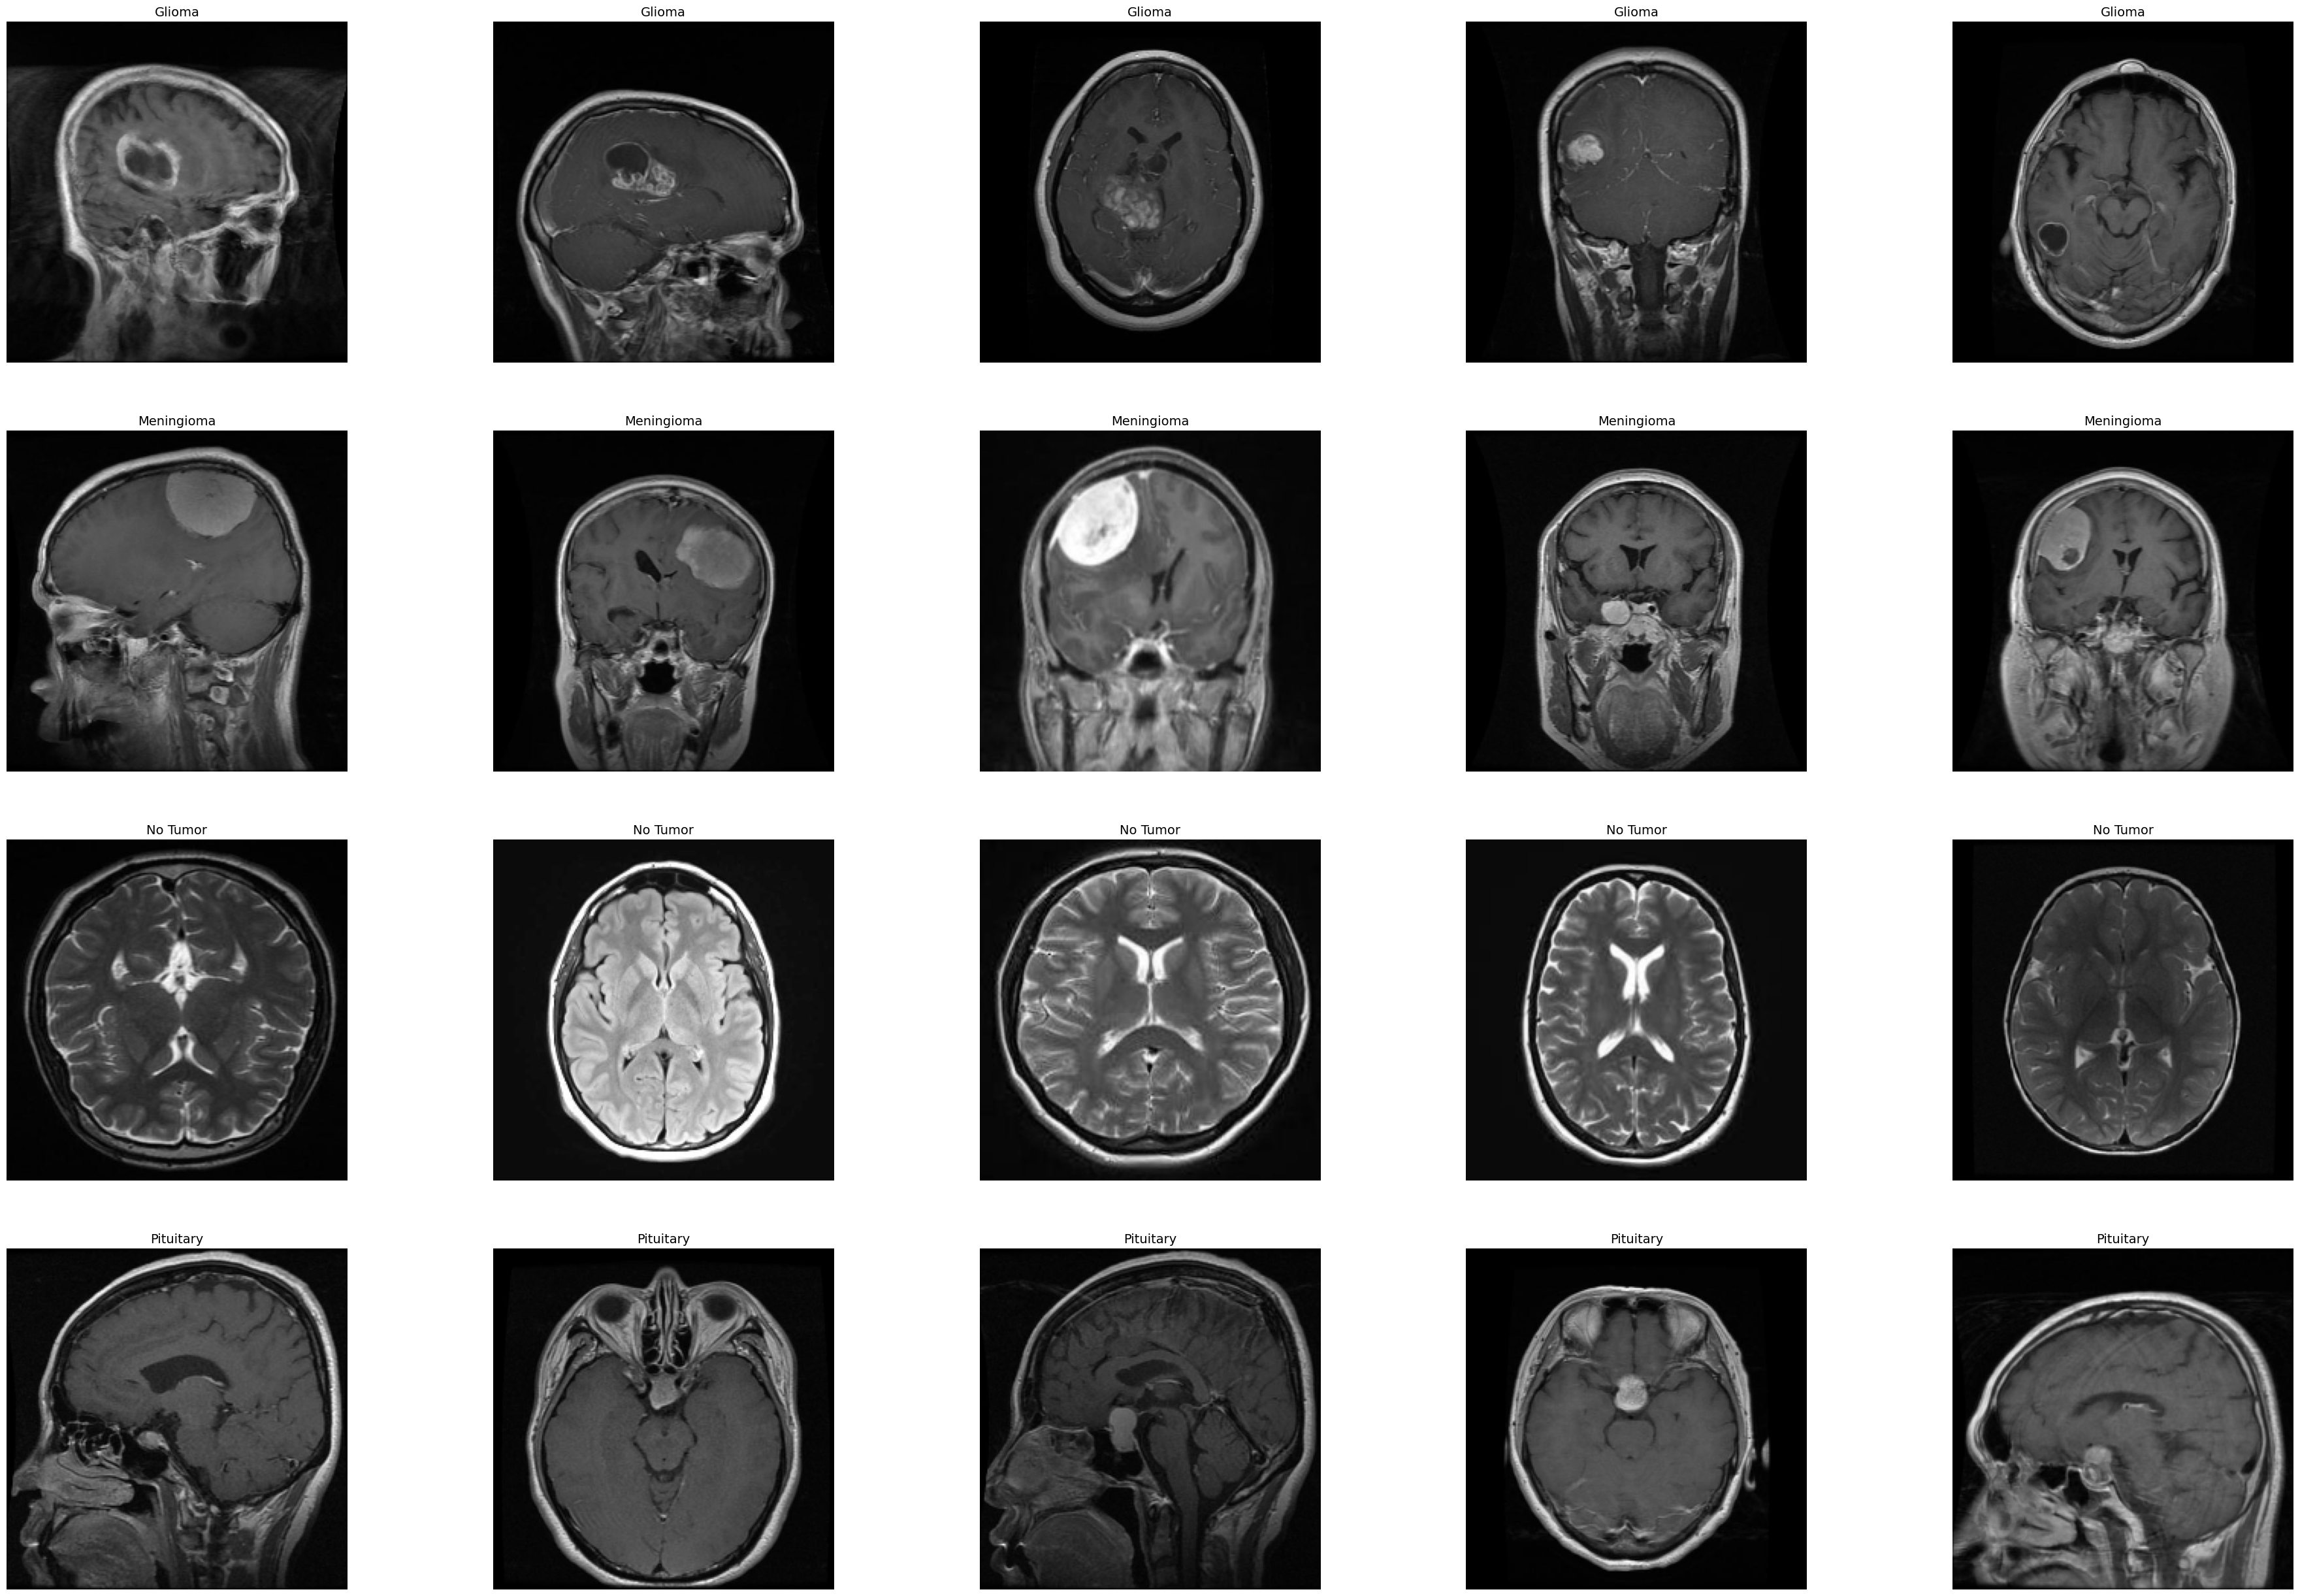

In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Sampling 5 images from each class (assuming you have 4 classes: 0, 1, 2, 3)
r_b = random.sample(list(np.where(np.array(train_labels) == 0)[0]), 5)
r_f = random.sample(list(np.where(np.array(train_labels) == 1)[0]), 5)
r_g = random.sample(list(np.where(np.array(train_labels) == 2)[0]), 5)
r_m = random.sample(list(np.where(np.array(train_labels) == 3)[0]), 5)

# Combine all the samples
plots = np.array([r_b + r_f + r_g + r_m][0])

# Reshape into 4 rows and 5 columns (4 * 5 = 20)
plots = plots.reshape(4, 5)

# Plot the images in a grid (4x5)
f, ax = plt.subplots(4, 5, figsize=(12, 8))  # Adjust figure size as needed
f.subplots_adjust(0, 0, 3, 3)

# Define the font size for the labels (titles)
font_size = 14

for i in range(0, 4, 1):
    for j in range(0, 5, 1):
        ax[i, j].imshow(train_data[plots[i, j]], cmap=plt.cm.gray)
        ax[i, j].set_title(class_names[train_labels[plots[i, j]]], fontsize=font_size)
        ax[i, j].axis('off')

plt.show()


In [ ]:
train_data, train_labels = shuffle(train_data, train_labels, random_state=12)

# Model Building and Training


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

import tensorflow as tf

input_shape = (224, 224, 1)  # Input shape for grayscale images

model = tf.keras.Sequential([
    # Resizing layer to resize the input images
    tf.keras.layers.Resizing(224, 224, interpolation='bilinear', input_shape=input_shape),

    # Block 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 4
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 5
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Classification head
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 139,585,476 (532.48 MB)

 Trainable params: 139,585,476 (532.48 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the path where the model with the best parameters will be saved
checkpoint_path = "best_model.keras"

# Create a callback that saves the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,
    save_weights_only=False,
    mode='max',  # Save when val_accuracy is maximized
    verbose=1
)

# Create an EarlyStopping callback with patience=5
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=10,  # Stop training if no improvement after 5 epochs
    mode='max',  # Check for maximization of val_accuracy
    verbose=1,
    restore_best_weights=True  # Restore model weights from the epoch with the best validation accuracy
)

# Train the model with the checkpoint and early stopping callbacks
history = model.fit(train_data, train_labels,
                    validation_split=0.2,
                    epochs=20,
                    batch_size=8,
                    callbacks=[checkpoint_callback, early_stopping_callback])


Epoch 1/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.4600 - loss: 1.2173
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to best_model.keras
474/474 ━━━━━━━━━━━━━━━━━━━━ 198s 364ms/step - accuracy: 0.4602 - loss: 1.2170 - val_accuracy: 0.0000e+00 - val_loss: 2.5684
Epoch 2/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7704 - loss: 0.6811
Epoch 2: val_accuracy did not improve from 0.00000
474/474 ━━━━━━━━━━━━━━━━━━━━ 122s 235ms/step - accuracy: 0.7704 - loss: 0.6810 - val_accuracy: 0.0000e+00 - val_loss: 2.1572
Epoch 3/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8329 - loss: 0.5306
Epoch 3: val_accuracy did not improve from 0.00000
474/474 ━━━━━━━━━━━━━━━━━━━━ 142s 235ms/step - accuracy: 0.8329 - loss: 0.5305 - val_accuracy: 0.0000e+00 - val_loss: 2.1083
Epoch 4/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8617 - loss: 0.4214
Epoch 4: val_accuracy improved from 0.00000 to 0.06329, saving model to best_model.ke

In [15]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, test_labels)
print(f"Test accuracy: {test_acc}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.9597 - loss: 0.1470
Test accuracy: 0.8984375


In [16]:
# Evaluate the model
train_loss, train_acc = model.evaluate(train_data, train_labels)
print(f"Train accuracy: {train_acc}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 26s 174ms/step - accuracy: 0.9923 - loss: 0.0273
Train accuracy: 0.9484906196594238


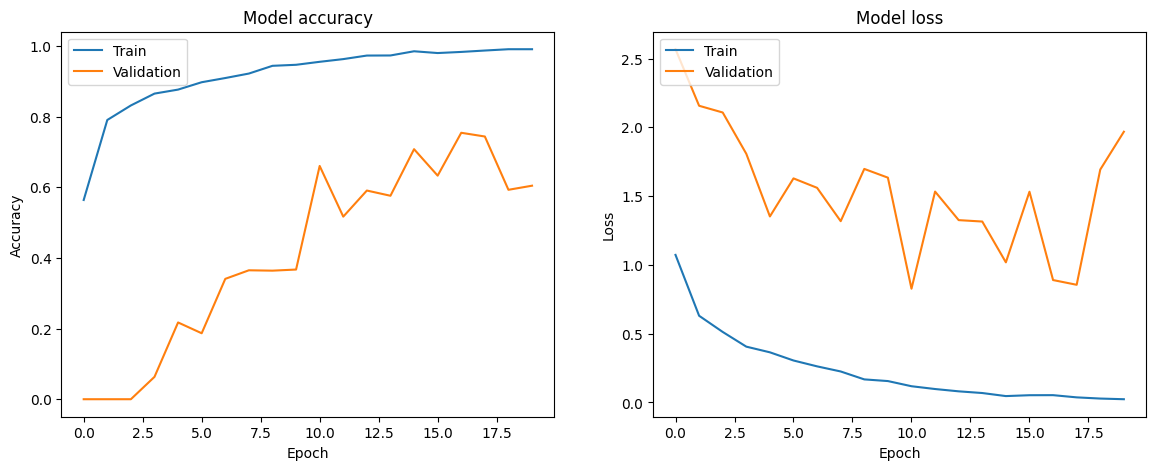

In [17]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step
Classification Report:
              precision    recall  f1-score   support

      Glioma       0.93      0.73      0.82       136
  Meningioma       0.77      0.93      0.84       140
    No Tumor       0.97      0.96      0.96       100
   Pituitary       0.97      0.99      0.98       136

    accuracy                           0.90       512
   macro avg       0.91      0.90      0.90       512
weighted avg       0.91      0.90      0.90       512

Precision: 0.9070473225836141
Recall: 0.8984375
F1-Score: 0.89739107469164


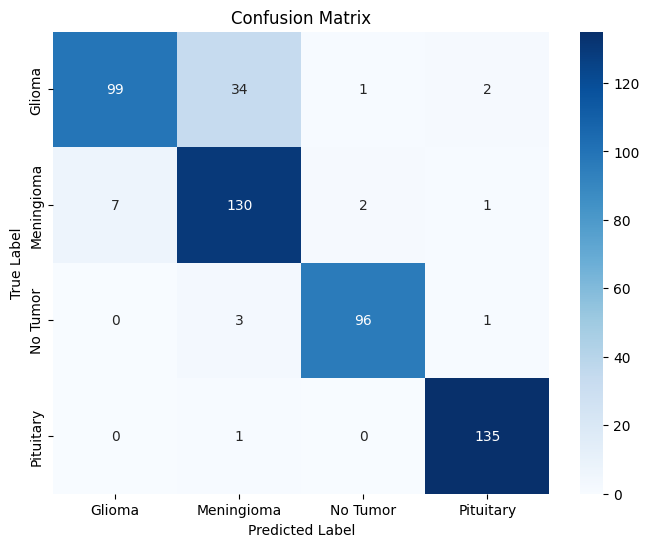

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict the classes on the test set
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Ensure test_labels is in single-label format if one-hot encoded
if len(test_labels.shape) > 1 and test_labels.shape[1] > 1:
    y_test_labels = np.argmax(test_labels, axis=1)
else:
    y_test_labels = test_labels

# Calculate precision, recall, and F1-score
precision = precision_score(y_test_labels, y_pred_classes, average='weighted')
recall = recall_score(y_test_labels, y_pred_classes, average='weighted')
f1 = f1_score(y_test_labels, y_pred_classes, average='weighted')

# Print classification report
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_classes, target_names=['Glioma','Meningioma','No Tumor', 'Pituitary']))

# Print precision, recall, and F1-score
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Glioma','Meningioma','No Tumor', 'Pituitary'], yticklabels=['Glioma','Meningioma','No Tumor', 'Pituitary'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Class names
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_classes)

# Initialize lists to store sensitivity and specificity for each class
sensitivities = []
specificities = []

# For each class, calculate sensitivity and specificity
for i in range(conf_matrix.shape[0]):
    # True Positives (TP): diagonal element of the confusion matrix
    TP = conf_matrix[i, i]

    # False Negatives (FN): sum of the row of the current class minus TP
    FN = conf_matrix[i, :].sum() - TP

    # False Positives (FP): sum of the column of the current class minus TP
    FP = conf_matrix[:, i].sum() - TP

    # True Negatives (TN): sum of all elements of the confusion matrix minus TP, FP, and FN
    TN = conf_matrix.sum() - (TP + FP + FN)

    # Calculate Sensitivity and Specificity for this class
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivities.append(sensitivity)
    specificities.append(specificity)

    # Print Sensitivity and Specificity for this class in the desired format
    print(f"{class_names[i]} - Sensitivity (True Positive Rate): {sensitivity:.4f}")
    print(f"{class_names[i]} - Specificity (True Negative Rate): {specificity:.4f}")
    print()


Glioma - Sensitivity (True Positive Rate): 0.7279
Glioma - Specificity (True Negative Rate): 0.9814

Meningioma - Sensitivity (True Positive Rate): 0.9286
Meningioma - Specificity (True Negative Rate): 0.8978

No Tumor - Sensitivity (True Positive Rate): 0.9600
No Tumor - Specificity (True Negative Rate): 0.9927

Pituitary - Sensitivity (True Positive Rate): 0.9926
Pituitary - Specificity (True Negative Rate): 0.9894

